We now compare the total computational time of FVM and PINN and try out other activation functions:

## FVM:

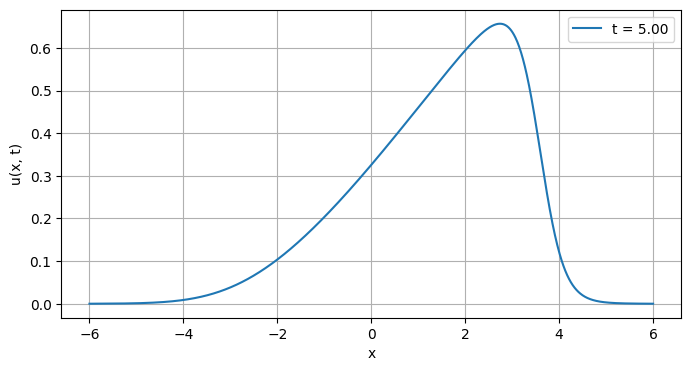

Time Taken: 26.8696 s


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

start_time_fvm = time.time()

# Parameters
mu = 0.1           
CFL = 0.4      
delta_x = 0.01     
nodes = 1200       
t_end = 5.0        

x = np.linspace(-6, 6, nodes + 1)

u = np.exp(-x**2 / 2)
t = 0.0

while t < t_end:
    
    u_max = max(np.max(np.abs(u)), mu/delta_x)
    delta_t = CFL * delta_x / u_max

    f = u**2 / 2
    unext = np.copy(u)

    for j in range(1, nodes-2):
        alpha_plus = max(abs(u[j]), abs(u[j + 1]))
        f_hat_plus = 0.5 * (f[j] + f[j + 1]) - 0.5 * alpha_plus * (u[j + 1] - u[j])

        alpha_minus = max(abs(u[j - 1]), abs(u[j]))
        f_hat_minus = 0.5 * (f[j - 1] + f[j]) - 0.5 * alpha_minus * (u[j] - u[j - 1])

        unext[j] = (
            u[j]
            - (delta_t / delta_x) * (f_hat_plus - f_hat_minus)
            + (mu * delta_t / delta_x**2) * (u[j + 1] - 2 * u[j] + u[j - 1])
        )

#Dirichlet Boundary Condition:
    unext[0] = 0.0       
    unext[-1] = 0.0

    u = unext.copy()
    t += delta_t


plt.figure(figsize=(8, 4))
plt.plot(x, u, label=f"t = {t:.2f}")
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.grid()
plt.legend()
plt.show()

end_time_fvm = time.time()
print(f"Time Taken: {end_time_fvm - start_time_fvm:.4f} s")

## PINN:

Using device: cuda


/home/pranay/miniconda3/envs/base10/lib/python3.10/site-packages/torch/autograd/graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0, Loss: 0.15631
Epoch 500, Loss: 0.00072
Epoch 1000, Loss: 0.00035
Epoch 1500, Loss: 0.00086
Epoch 2000, Loss: 0.00007
Epoch 2500, Loss: 0.00004
Epoch 3000, Loss: 0.00003
Epoch 3500, Loss: 0.00002
Epoch 4000, Loss: 0.00002
Epoch 4500, Loss: 0.00001


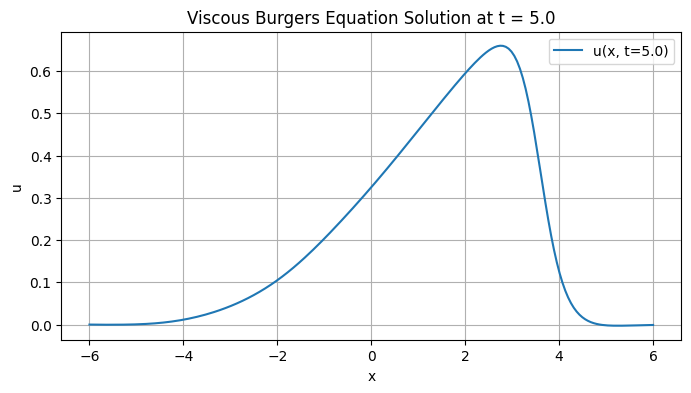

Time Taken: 32.8516 s


In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time

start_time = time.time()

torch.set_default_dtype(torch.float)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.net = nn.Sequential()
        for i in range(len(layers) - 1):
            self.net.add_module(f"layer_{i}", nn.Linear(layers[i], layers[i+1]))
            if i != len(layers) - 2:
                self.net.add_module(f"tanh_{i}", nn.Tanh())

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        return self.net(inputs)

        
def pde_residual(model, x, t, mu):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    return u_t + u * u_x - mu * u_xx

#Parameters
mu = 0.1
layers = [2, 64, 64, 64, 1]
model = PINN(layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#Collocation points (interior of the domain)
N_f = 10000
x_f = torch.FloatTensor(N_f, 1).uniform_(-6, 6).to(device)
t_f = torch.FloatTensor(N_f, 1).uniform_(0, 5).to(device)

#Initial condition
N_ic = 200
x_ic = torch.linspace(-6, 6, N_ic).reshape(-1, 1).to(device)
t_ic = torch.zeros_like(x_ic)
u_ic = torch.exp(-((x_ic)**2)/2)

#Boundary conditions
N_bc = 200
t_bc = torch.linspace(0, 5, N_bc).reshape(-1, 1).to(device)
x_bc0 = -6 * torch.ones_like(t_bc)
x_bc1 =  6 * torch.ones_like(t_bc)
u_bc0 = torch.zeros_like(x_bc0)
u_bc1 = torch.zeros_like(x_bc1)

#Training
for epoch in range(5000):
    optimizer.zero_grad()

    #PDE loss (collocation points)
    f = pde_residual(model, x_f, t_f, mu)
    loss_f = torch.mean(f**2)

    #Initial condition loss
    u_pred_ic = model(x_ic, t_ic)
    loss_ic = torch.mean((u_pred_ic - u_ic)**2)

    #Boundary condition loss
    u_pred_bc0 = model(x_bc0, t_bc)
    u_pred_bc1 = model(x_bc1, t_bc)
    loss_bc = torch.mean((u_pred_bc0 - u_bc0)**2) + torch.mean((u_pred_bc1 - u_bc1)**2)

    #Total loss
    loss = loss_f + loss_ic + loss_bc
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5f}")

#u at t = 5
x_plot = torch.linspace(-6, 6, 200).reshape(-1, 1).to(device)
t_plot = 5.0 * torch.ones_like(x_plot)
u_plot = model(x_plot, t_plot).detach().cpu().numpy()

plt.figure(figsize=(8, 4))
plt.plot(x_plot.cpu().numpy(), u_plot, label='u(x, t=5.0)')
plt.title('Viscous Burgers Equation Solution at t = 5.0')
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.legend()
plt.show()

end_time = time.time()
print(f"Time Taken: {end_time - start_time:.4f} s")

We now try other activation functions:

### A. SiLU Activation Function:
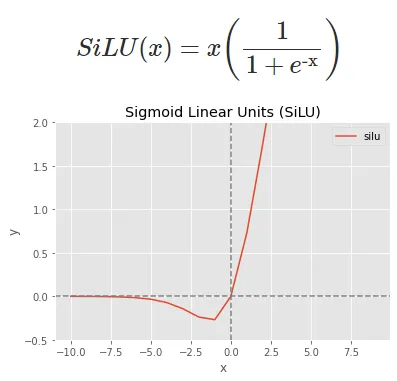

Using device: cuda
Epoch 0, Loss: 0.16086
Epoch 500, Loss: 0.00089
Epoch 1000, Loss: 0.00045
Epoch 1500, Loss: 0.00013
Epoch 2000, Loss: 0.00007
Epoch 2500, Loss: 0.00004
Epoch 3000, Loss: 0.00002
Epoch 3500, Loss: 0.00001
Epoch 4000, Loss: 0.00001
Epoch 4500, Loss: 0.00000


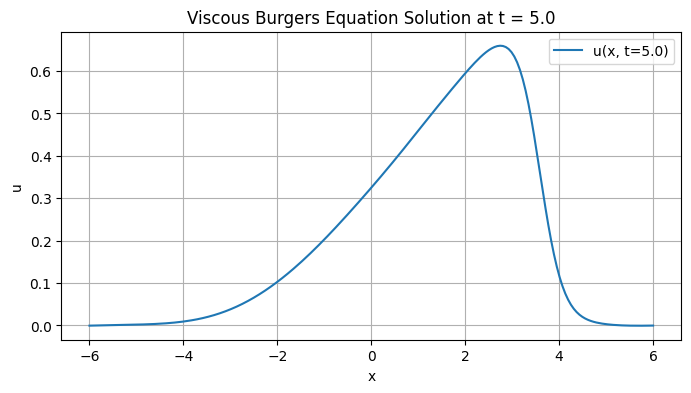

Time Taken: 83.2879 s


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time

start_time = time.time()

torch.set_default_dtype(torch.float)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.net = nn.Sequential()

        activation_fn = nn.SiLU()      ## SiLU activation function

        for i in range(len(layers) - 1):
            self.net.add_module(f"layer_{i}", nn.Linear(layers[i], layers[i+1]))
            if i != len(layers) - 2:
                self.net.add_module(f"tanh_{i}", activation_fn)

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        return self.net(inputs)

        
def pde_residual(model, x, t, mu):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    return u_t + u * u_x - mu * u_xx

#Parameters
mu = 0.1
layers = [2, 64, 64, 64, 1]
model = PINN(layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#Collocation points (interior of the domain)
N_f = 10000
x_f = torch.FloatTensor(N_f, 1).uniform_(-6, 6).to(device)
t_f = torch.FloatTensor(N_f, 1).uniform_(0, 5).to(device)

#Initial condition
N_ic = 200
x_ic = torch.linspace(-6, 6, N_ic).reshape(-1, 1).to(device)
t_ic = torch.zeros_like(x_ic)
u_ic = torch.exp(-((x_ic)**2)/2)

#Boundary conditions
N_bc = 200
t_bc = torch.linspace(0, 5, N_bc).reshape(-1, 1).to(device)
x_bc0 = -6 * torch.ones_like(t_bc)
x_bc1 =  6 * torch.ones_like(t_bc)
u_bc0 = torch.zeros_like(x_bc0)
u_bc1 = torch.zeros_like(x_bc1)

#Training
for epoch in range(5000):
    optimizer.zero_grad()

    #PDE loss (collocation points)
    f = pde_residual(model, x_f, t_f, mu)
    loss_f = torch.mean(f**2)

    #Initial condition loss
    u_pred_ic = model(x_ic, t_ic)
    loss_ic = torch.mean((u_pred_ic - u_ic)**2)

    #Boundary condition loss
    u_pred_bc0 = model(x_bc0, t_bc)
    u_pred_bc1 = model(x_bc1, t_bc)
    loss_bc = torch.mean((u_pred_bc0 - u_bc0)**2) + torch.mean((u_pred_bc1 - u_bc1)**2)

    #Total loss
    loss = loss_f + loss_ic + loss_bc
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5f}")

#u at t = 5
x_plot = torch.linspace(-6, 6, 200).reshape(-1, 1).to(device)
t_plot = 5.0 * torch.ones_like(x_plot)
u_plot = model(x_plot, t_plot).detach().cpu().numpy()

plt.figure(figsize=(8, 4))
plt.plot(x_plot.cpu().numpy(), u_plot, label='u(x, t=5.0)')
plt.title('Viscous Burgers Equation Solution at t = 5.0')
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.legend()
plt.show()

end_time = time.time()
print(f"Time Taken: {end_time - start_time:.4f} s")

### B. Leaky ReLU
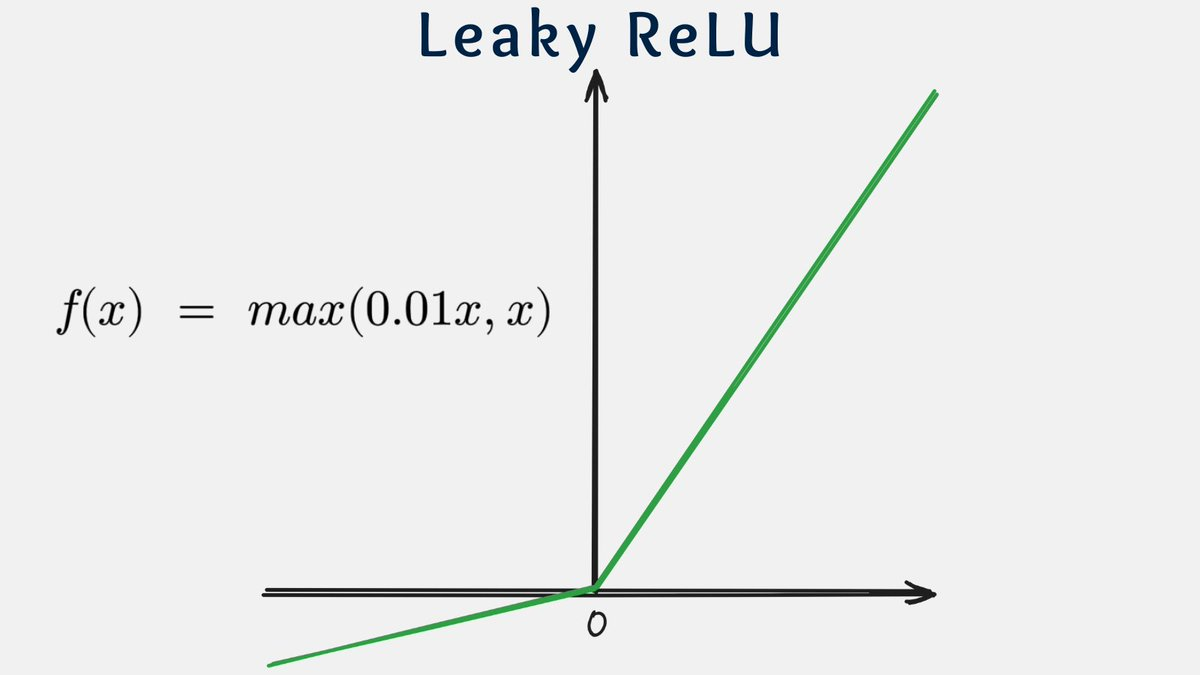

Using device: cuda
Epoch 0, Loss: 0.37347
Epoch 500, Loss: 0.00235
Epoch 1000, Loss: 0.00269
Epoch 1500, Loss: 0.00321
Epoch 2000, Loss: 0.00266
Epoch 2500, Loss: 0.00295
Epoch 3000, Loss: 0.00264
Epoch 3500, Loss: 0.00263
Epoch 4000, Loss: 0.00329
Epoch 4500, Loss: 0.00404


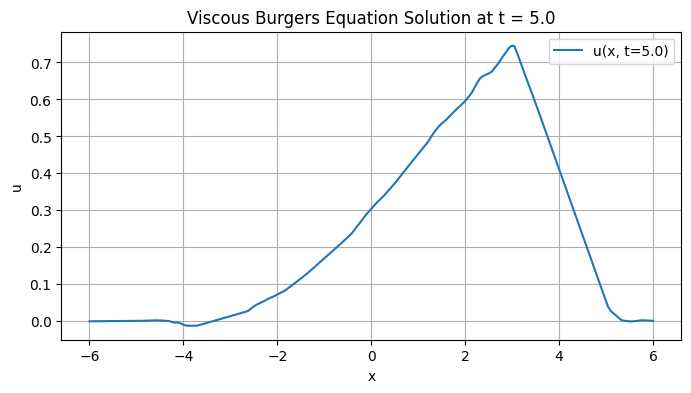

Time Taken: 34.3979 s


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time

start_time = time.time()

torch.set_default_dtype(torch.float)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.net = nn.Sequential()

        activation_fn = nn.LeakyReLU(negative_slope=0.01)    ## Leaky ReLU activation function

        for i in range(len(layers) - 1):
            self.net.add_module(f"layer_{i}", nn.Linear(layers[i], layers[i+1]))
            if i != len(layers) - 2:
                self.net.add_module(f"tanh_{i}", activation_fn)

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        return self.net(inputs)

        
def pde_residual(model, x, t, mu):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    return u_t + u * u_x - mu * u_xx

#Parameters
mu = 0.1
layers = [2, 64, 64, 64, 1]
model = PINN(layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#Collocation points (interior of the domain)
N_f = 10000
x_f = torch.FloatTensor(N_f, 1).uniform_(-6, 6).to(device)
t_f = torch.FloatTensor(N_f, 1).uniform_(0, 5).to(device)

#Initial condition
N_ic = 200
x_ic = torch.linspace(-6, 6, N_ic).reshape(-1, 1).to(device)
t_ic = torch.zeros_like(x_ic)
u_ic = torch.exp(-((x_ic)**2)/2)

#Boundary conditions
N_bc = 200
t_bc = torch.linspace(0, 5, N_bc).reshape(-1, 1).to(device)
x_bc0 = -6 * torch.ones_like(t_bc)
x_bc1 =  6 * torch.ones_like(t_bc)
u_bc0 = torch.zeros_like(x_bc0)
u_bc1 = torch.zeros_like(x_bc1)

#Training
for epoch in range(5000):
    optimizer.zero_grad()

    #PDE loss (collocation points)
    f = pde_residual(model, x_f, t_f, mu)
    loss_f = torch.mean(f**2)

    #Initial condition loss
    u_pred_ic = model(x_ic, t_ic)
    loss_ic = torch.mean((u_pred_ic - u_ic)**2)

    #Boundary condition loss
    u_pred_bc0 = model(x_bc0, t_bc)
    u_pred_bc1 = model(x_bc1, t_bc)
    loss_bc = torch.mean((u_pred_bc0 - u_bc0)**2) + torch.mean((u_pred_bc1 - u_bc1)**2)

    #Total loss
    loss = loss_f + loss_ic + loss_bc
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5f}")

#u at t = 5
x_plot = torch.linspace(-6, 6, 200).reshape(-1, 1).to(device)
t_plot = 5.0 * torch.ones_like(x_plot)
u_plot = model(x_plot, t_plot).detach().cpu().numpy()

plt.figure(figsize=(8, 4))
plt.plot(x_plot.cpu().numpy(), u_plot, label='u(x, t=5.0)')
plt.title('Viscous Burgers Equation Solution at t = 5.0')
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.legend()
plt.show()

end_time = time.time()
print(f"Time Taken: {end_time - start_time:.4f} s")

Unlike SiLU and Tanh activation functions, leaky ReLU does't work quite well. This is because second derivative of ReLU is zero everywhere in its domain thus ignoring the diffusive term of the PDE while training the model on initial and boundary conditions.

### C. GELU
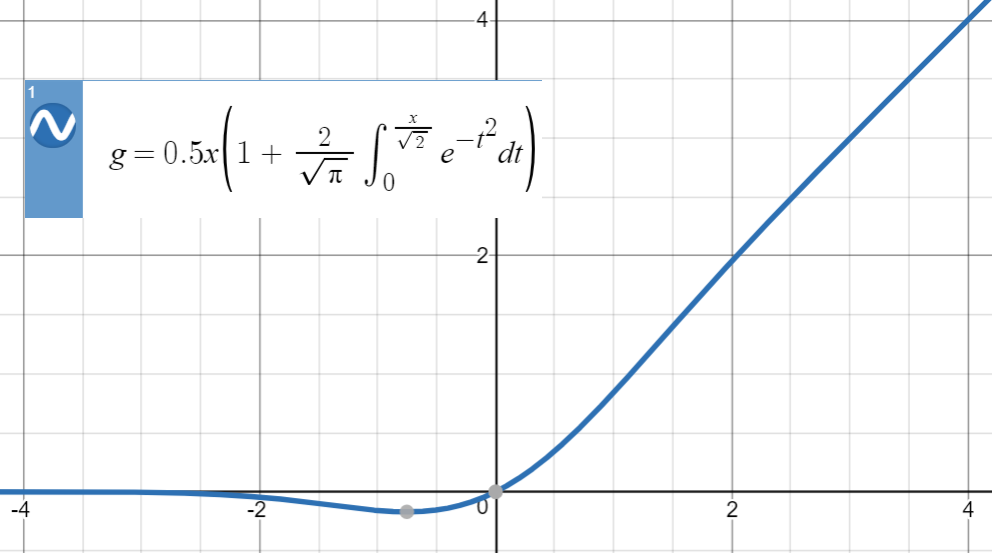

Using device: cuda
Epoch 0, Loss: 0.22470
Epoch 500, Loss: 0.00037
Epoch 1000, Loss: 0.00011
Epoch 1500, Loss: 0.00004
Epoch 2000, Loss: 0.00002
Epoch 2500, Loss: 0.00001
Epoch 3000, Loss: 0.00001
Epoch 3500, Loss: 0.00000
Epoch 4000, Loss: 0.00000
Epoch 4500, Loss: 0.00002


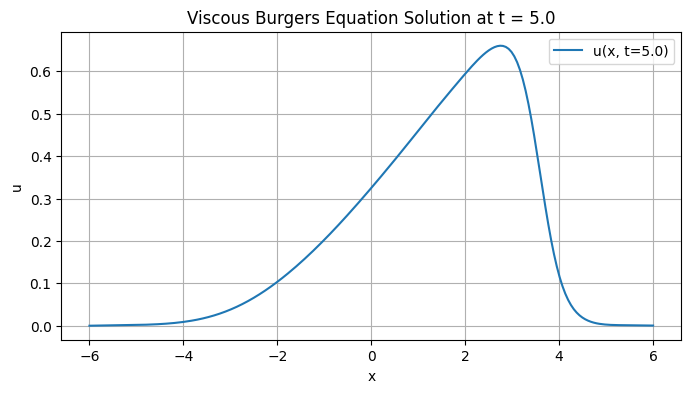

Time Taken: 51.9472 s


In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time

start_time = time.time()

torch.set_default_dtype(torch.float)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.net = nn.Sequential()

        activation_fn = nn.GELU()  ## Leaky ReLU activation function

        for i in range(len(layers) - 1):
            self.net.add_module(f"layer_{i}", nn.Linear(layers[i], layers[i+1]))
            if i != len(layers) - 2:
                self.net.add_module(f"tanh_{i}", activation_fn)

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        return self.net(inputs)

        
def pde_residual(model, x, t, mu):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    return u_t + u * u_x - mu * u_xx

#Parameters
mu = 0.1
layers = [2, 64, 64, 64, 1]
model = PINN(layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#Collocation points (interior of the domain)
N_f = 10000
x_f = torch.FloatTensor(N_f, 1).uniform_(-6, 6).to(device)
t_f = torch.FloatTensor(N_f, 1).uniform_(0, 5).to(device)

#Initial condition
N_ic = 200
x_ic = torch.linspace(-6, 6, N_ic).reshape(-1, 1).to(device)
t_ic = torch.zeros_like(x_ic)
u_ic = torch.exp(-((x_ic)**2)/2)

#Boundary conditions
N_bc = 200
t_bc = torch.linspace(0, 5, N_bc).reshape(-1, 1).to(device)
x_bc0 = -6 * torch.ones_like(t_bc)
x_bc1 =  6 * torch.ones_like(t_bc)
u_bc0 = torch.zeros_like(x_bc0)
u_bc1 = torch.zeros_like(x_bc1)

#Training
for epoch in range(5000):
    optimizer.zero_grad()

    #PDE loss (collocation points)
    f = pde_residual(model, x_f, t_f, mu)
    loss_f = torch.mean(f**2)

    #Initial condition loss
    u_pred_ic = model(x_ic, t_ic)
    loss_ic = torch.mean((u_pred_ic - u_ic)**2)

    #Boundary condition loss
    u_pred_bc0 = model(x_bc0, t_bc)
    u_pred_bc1 = model(x_bc1, t_bc)
    loss_bc = torch.mean((u_pred_bc0 - u_bc0)**2) + torch.mean((u_pred_bc1 - u_bc1)**2)

    #Total loss
    loss = loss_f + loss_ic + loss_bc
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5f}")

#u at t = 5
x_plot = torch.linspace(-6, 6, 200).reshape(-1, 1).to(device)
t_plot = 5.0 * torch.ones_like(x_plot)
u_plot = model(x_plot, t_plot).detach().cpu().numpy()

plt.figure(figsize=(8, 4))
plt.plot(x_plot.cpu().numpy(), u_plot, label='u(x, t=5.0)')
plt.title('Viscous Burgers Equation Solution at t = 5.0')
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.legend()
plt.show()

end_time = time.time()
print(f"Time Taken: {end_time - start_time:.4f} s")